# Imports

In [15]:
import math
import os
import torch
import torch.distributions.constraints as constraints
import pyro
import numpy as np
import copy
import time
import snakeviz
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
import pyro.distributions as dist
import random
from sklearn.datasets import load_diabetes
assert pyro.__version__.startswith('1.8.4')

# clear the param store in case we're in a REPL
pyro.clear_param_store()

# Load Datasets

### Random Dataset

In [16]:
def generate_stdp_dataset(dim, num_examples, min_value, max_value):
    X = np.random.random((num_examples + 1, dim)) * (max_value - min_value) + min_value
    beta = np.random.random((dim)) * (max_value - min_value) + min_value

    noise = np.random.normal(0, np.sqrt(max_value - min_value), num_examples + 1)
    Y = X[:num_examples + 1] @ beta + noise

    X = np.asfortranarray(X)
    Y = np.asfortranarray(Y)
    X /= np.linalg.norm(X, axis=0)
    Y = (Y - Y.mean()) / Y.std()
    Y = Y * max_value

    Y = Y/np.linalg.norm(Y)

    return X, Y, beta

In [17]:
X, Y, beta = generate_stdp_dataset(10, 442, 0, 1)

### Diabetes Dataset

X, Y = load_diabetes(return_X_y = True)

print(Y[0:3])
Y = (Y - Y.mean()) / Y.std()
print(Y[0:3])
X = X / np.linalg.norm(X)
print(X[0:3])

In [18]:
print(X)
print(Y)

[[0.01612398 0.04158464 0.07746244 ... 0.03498206 0.02095555 0.04236454]
 [0.01605905 0.04527719 0.07404861 ... 0.05604785 0.00128957 0.06493875]
 [0.01929939 0.04572011 0.02101049 ... 0.06714217 0.04359674 0.07518022]
 ...
 [0.02848631 0.04489719 0.07742571 ... 0.06421913 0.03564968 0.06717425]
 [0.06420379 0.08492299 0.02663652 ... 0.06847802 0.01271459 0.03142911]
 [0.07088772 0.00124826 0.05961029 ... 0.07227652 0.07289808 0.07222616]]
[ 0.10507839 -0.04747196  0.03105699  0.02568808  0.02804387 -0.05533747
  0.03328622 -0.04039671 -0.01771471 -0.02467857 -0.00096428 -0.05590712
 -0.05880182 -0.01092552  0.01193904  0.00734534  0.06541654 -0.03333717
 -0.00267866  0.00992587 -0.05686197  0.02617897  0.08011135  0.00761401
  0.02006333 -0.03767134  0.04421853 -0.03023551  0.03999766  0.01656581
  0.02797752  0.04405204 -0.00138823 -0.05668539  0.05178921 -0.01079294
  0.00527193  0.04752734 -0.03364545 -0.02525739 -0.01153545  0.00570534
  0.02031529  0.02662051 -0.09891087  0.05037

In [19]:
print(len(X[0]))

10


In [20]:
# Clip the dataset
# X = X[0:100]
# Y = Y[0:100]

### Set up X, Y train

In [21]:
X_train = copy.deepcopy(X)
Y_train = copy.deepcopy(Y[:len(Y) - 1])
X_train = [torch.tensor(member) for member in X_train]
Y_train = [torch.tensor(member) for member in Y_train]
dim = len(X[0])

In [22]:
np.std(Y_train)

0.04748028659696564

# Model and Guide Setup

In [23]:
global prev_mu_q

prev_mu_q = torch.zeros(dim, dtype=torch.float64)

In [24]:
def model(data):
    # define the hyperparameters that control the Beta prior
    mu0 = torch.zeros(dim, dtype=torch.float64)
    b = pyro.sample("b", dist.Gamma(torch.ones(dim, dtype=torch.float64), torch.ones(dim, dtype=torch.float64)).to_event(1))
    # sample f from the Beta prior
    beta = pyro.sample("beta", dist.Laplace(mu0, b).to_event(1))
    std = pyro.sample("sigma", dist.HalfNormal(1))
    # loop over the observed data
    # subset = random.sample(data, int(len(data) / dim))
    # for i in range(len(subset)):
    # data goes list tuple tensor
          
    with pyro.plate("data", len(data), subsample_size=100) as ind:
        data = np.asarray(data)[ind]
        for i in range(len(data)):
            sampler = dist.Normal(beta.dot(data[i][0]).item(), std)
            pyro.sample("obs_{}".format(i), sampler.to_event(0), obs=data[i][1])

# NOT being used in favor of autoguide
def guide(data):
    return pyro.infer.autoguide.AutoLaplaceApproximation(model)

In [25]:
def train_SVI(D_hat, n_steps):
    losses = []
    # setup the optimizer
    adam_params = {"lr": 0.005, "betas": (0.90, 0.999)}
    optimizer = Adam(adam_params)

    # setup the inference algorithm
    guide = pyro.infer.autoguide.AutoLaplaceApproximation(model)
    svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
    # do gradient steps
    for step in range(n_steps):
        loss = svi.step(D_hat)
        losses.append(loss)
        if loss < 1e-5:
            break
    breakpoint()
    mu_q = guide.state_dict()['loc'][10:20]
    return mu_q, losses

# Run VI on Data 

In [26]:
rank_proportions = []
y_hat = max(Y_train)
y_bottom = min(Y_train)
print(y_hat)
print(y_bottom)
conformal_set = []
decrease_size = 0.01
start = time.time()
print(max(Y_train))
print(min(Y_train))

all_losses = []
while y_hat >= y_bottom:
    pyro.clear_param_store()
    # Create D_hat
    D_hat = list(zip(X_train[:-1], Y_train))
    D_hat.append((X_train[-1], y_hat))
    
    # Train SVI
    mu_q, losses = train_SVI(D_hat, 200)
    all_losses.append(losses)
    prev_mu_q = mu_q
    
    # Calculate rank of y_hat
    rank = [(abs(sum(D_hat[i][0] * mu_q) - D_hat[i][1]).detach().numpy()) for i in range(len(D_hat))]
    y_hat_rank = rank[-1]
    
    # Add to conformal set if in not in bottom 10 percent of probabilities
    current_rank_proportion = np.count_nonzero(y_hat_rank > rank) / len(rank)
    rank_proportions.append(current_rank_proportion)
    if current_rank_proportion < 0.9:
        conformal_set.append(copy.deepcopy(y_hat))
        print(f"{y_hat} Added")
    else:
        print(f"{y_hat} Not added")
    y_hat -= decrease_size
conformal_set = [min(conformal_set), max(conformal_set)]
end = time.time()

tensor(0.1419, dtype=torch.float64)
tensor(-0.1240, dtype=torch.float64)
tensor(0.1419, dtype=torch.float64)
tensor(-0.1240, dtype=torch.float64)


/var/folders/1s/1mkc4t8137lbs9x8hhg9q8940000gp/T/ipykernel_13566/500303095.py:14: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  data = np.asarray(data)[ind]
/var/folders/1s/1mkc4t8137lbs9x8hhg9q8940000gp/T/ipykernel_13566/500303095.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.asarray(data)[ind]


0.1418706916720681 Not added
0.13187069167206808 Not added
0.12187069167206808 Not added
0.11187069167206809 Not added
0.1018706916720681 Not added
0.0918706916720681 Added
0.0818706916720681 Added
0.07187069167206811 Added
0.06187069167206811 Added
0.051870691672068106 Added
0.041870691672068104 Added
0.0318706916720681 Added
0.0218706916720681 Added
0.0118706916720681 Added
0.0018706916720680998 Added
-0.0081293083279319 Added
-0.0181293083279319 Added
-0.028129308327931903 Added
-0.038129308327931904 Added
-0.048129308327931906 Added
-0.05812930832793191 Added
-0.0681293083279319 Added
-0.0781293083279319 Added
-0.0881293083279319 Not added
-0.09812930832793189 Not added
-0.10812930832793188 Not added
-0.11812930832793188 Not added


In [27]:
print(f"Conformal Set: [{float(conformal_set[0])}, {float(conformal_set[1])}]")
print(f"Length: {float(conformal_set[1] - conformal_set[0])}")
print(f"Y[-1]: {Y[-1]}")
if Y[-1] >= conformal_set[0] and Y[-1] <= conformal_set[1]:
    print(f"Y[-1] is covered")
else:
    print("Y[-1] is Not covered")
print(f"Elapsed Time: {end - start}")

Conformal Set: [-0.0781293083279319, 0.0918706916720681]
Length: 0.16999999999999998
Y[-1]: 0.05964097926622981
Y[-1] is covered
Elapsed Time: 88.12924289703369


In [28]:
print(all_losses[0])

[47661.99328416252, 47441.035040902585, 47218.55972980891, 46994.923088916345, 46781.83283576046, 46550.70033684787, 46337.409872675395, 46116.40381412186, 45889.92158381861, 45673.22857431617, 45435.60564174207, 45220.1359103474, 44994.79677402221, 44785.81525895179, 44567.89630853105, 44341.40363412309, 44123.903124088894, 43894.61504846625, 43680.41822141253, 43450.7133369652, 43228.695790795406, 43005.93923162551, 42780.71538746437, 42573.83511089968, 42349.953990009126, 42126.774944938974, 41909.073295373186, 41683.72195909084, 41457.09305365548, 41242.88568764709, 41017.21129991587, 40792.65224454017, 40589.19218010839, 40357.22243185499, 40131.57551462411, 39921.322294727936, 39693.630133743354, 39486.42158400618, 39253.93581321011, 39038.03751548858, 38800.14985866673, 38584.610365494584, 38383.19563499177, 38136.30838745117, 37934.99078813498, 37696.07288463612, 37489.24262294975, 37256.73403890034, 37051.409927684144, 36816.46860623992, 36603.84284250657, 36385.7518095519, 36

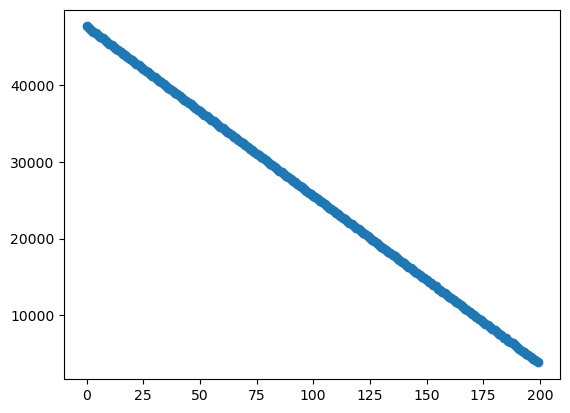

In [33]:
import matplotlib.pyplot as plt
plt.scatter(range(len(all_losses[0])), all_losses[0])
plt.show()

In [34]:
print(mu_q)

tensor([-4.3821e-02,  1.1268e-04,  5.8331e-04,  6.6335e-04, -4.0176e-04,
         1.0043e-03,  6.4395e-04, -3.5384e-05,  8.7944e-05, -4.7360e-04],
       dtype=torch.float64)


In [31]:
pyro.get_param_store().keys()

dict_keys(['AutoLaplaceApproximation.loc'])